# Cell 0. Original Model

- 기존 코드에서 best_overall_model.pth만 불러옴

c:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\utils.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.data = torch.tensor(self.data, dtype=torch.float32).unsqueeze(1)



✅ Pre-trained model found. Skipping training.

📌 Original Model - Classification Report:
              precision    recall  f1-score   support

           N       1.00      1.00      1.00       160
          IR       0.97      0.93      0.95       121
       OR@06       0.94      0.97      0.95       120
           B       0.92      0.94      0.93       120

    accuracy                           0.96       521
   macro avg       0.96      0.96      0.96       521
weighted avg       0.96      0.96      0.96       521



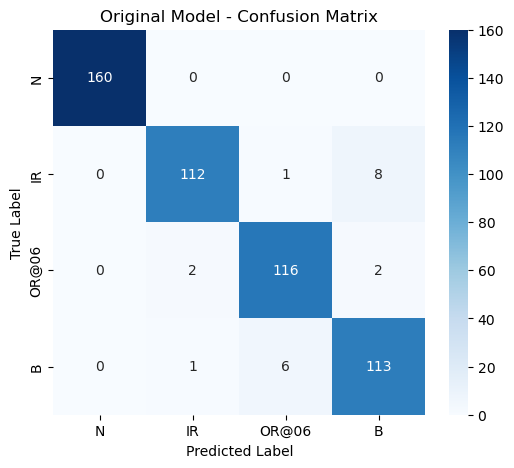

In [2]:
import os
import torch
import pickle
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from model import WDCNN
from utils import (
    set_seed,

    # 데이터셋 및 학습 관련 함수
    CWRUDataset, train_original_model_with_batch_sizes, 
    fine_tune_unstructured, fine_tune_structured,
    plot_unstructured_pruning_results, plot_structured_pruning_results,
    
    # Pruning 적용 함수
    apply_sparse_training, apply_structured_pruning,
    remove_pruning_and_save_unstructured, remove_pruning_and_save_structured,

    # 평가 함수
    evaluate_classification, measure_inference_time, evaluate_test_performance_structured, evaluate_test_performance_unstructured,
    count_total_parameters, count_nonzero_parameters,

    # 변수 (경로)
    parameter_dir, original_path, unstructured_path, structured_path,
    load_unstructured_results, load_structured_results
)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 🔹 Dataset 로드
# ============================================================
train_dataset, val_dataset, test_dataset = (
    CWRUDataset("Train"), CWRUDataset("Validation"), CWRUDataset("Test")
)

# train_loader, val_loader는 어차피 train_original_model_with_batch_sizes 여기서 다시 설정
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ============================================================
# 🔹 Original Model 학습 여부 체크 및 로드
# ============================================================
best_model_path = os.path.join(original_path, "best_overall_model.pth")

if not os.path.exists(best_model_path):
    print("\n🔹 No pre-trained model found. Starting training...")
    train_original_model_with_batch_sizes(train_dataset, val_dataset)
else:
    print("\n✅ Pre-trained model found. Skipping training.")

# ✅ Original Model 로드
original_model = WDCNN().to(device)
original_model.load_state_dict(torch.load(best_model_path, map_location=device))

# ✅ Original Model Classification Report & Confusion Matrix
evaluate_classification(original_model, test_loader, device, title="Original Model")


<Best Model 정보> - 변동 없음
- Batch size : 
실험 조건
- lr
- optimizer
- weight decay
- lr scheduling (patience)
- early stop
- 

## Cell 0.1 재구현

c:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\utils.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.data = torch.tensor(self.data, dtype=torch.float32).unsqueeze(1)


✅ 초기 가중치 로드 완료: C:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\Parameters\Original\initial_weights_bs256.pth


c:\Users\ChoiSeongHyeon\anaconda3\envs\WinningT\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Acc: 0.6078, Val Acc: 0.3205
Epoch 2: Train Acc: 0.8316, Val Acc: 0.4069
Epoch 3: Train Acc: 0.8759, Val Acc: 0.4856
Epoch 4: Train Acc: 0.9003, Val Acc: 0.5777
Epoch 5: Train Acc: 0.8834, Val Acc: 0.6699
Epoch 6: Train Acc: 0.9038, Val Acc: 0.7236
Epoch 7: Train Acc: 0.8980, Val Acc: 0.7620
Epoch 8: Train Acc: 0.8916, Val Acc: 0.8061
Epoch 9: Train Acc: 0.9015, Val Acc: 0.7543
Epoch 10: Train Acc: 0.9027, Val Acc: 0.7332
Epoch 11: Train Acc: 0.9231, Val Acc: 0.7946
Epoch 12: Train Acc: 0.9213, Val Acc: 0.6929
Epoch 13: Train Acc: 0.9633, Val Acc: 0.8445
Epoch 14: Train Acc: 0.9336, Val Acc: 0.7697
Epoch 15: Train Acc: 0.9784, Val Acc: 0.6430
Epoch 16: Train Acc: 0.9854, Val Acc: 0.7255
Epoch 17: Train Acc: 0.9889, Val Acc: 0.8656
Epoch 18: Train Acc: 0.9913, Val Acc: 0.7946
Epoch 19: Train Acc: 0.9814, Val Acc: 0.8004
Epoch 20: Train Acc: 0.9942, Val Acc: 0.6027
Epoch 21: Train Acc: 0.9953, Val Acc: 0.7505
Epoch 22: Train Acc: 0.9948, Val Acc: 0.9040
Epoch 23: Train Acc

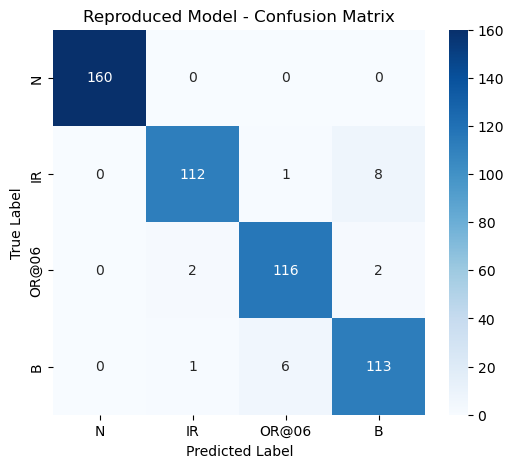

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from model import WDCNN
from utils import CWRUDataset, original_path, set_seed


def evaluate_classification(model, test_loader, device, title="Model Evaluation"):
    """Test Dataset에서 Classification Report 및 Confusion Matrix 출력"""
    model.to(device)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    print(f"\n📌 {title} - Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['N', 'IR', 'OR@06', 'B']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['N', 'IR', 'OR@06', 'B'], yticklabels=['N', 'IR', 'OR@06', 'B'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{title} - Confusion Matrix")
    plt.show()


def train_with_loaded_initial_weights(train_dataset, val_dataset, test_loader, batch_size=256, num_epochs=500, learning_rate=0.01, patience=200):
    """저장된 초기 가중치를 로드하여 재학습 및 성능 재현 검증"""
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ✅ 초기 가중치 로드
    init_weights_path = os.path.join(original_path, f"initial_weights_bs{batch_size}.pth")

    if not os.path.exists(init_weights_path):
        raise FileNotFoundError(f"❌ 초기 가중치 파일이 없습니다: {init_weights_path}")

    model = WDCNN().to(device)
    model.load_state_dict(torch.load(init_weights_path, map_location=device))
    print(f"✅ 초기 가중치 로드 완료: {init_weights_path}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

    best_val_acc = 0.0
    best_model_state = None
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        train_acc = train_correct / len(train_loader.dataset)

        # 🔹 Validation
        model.eval()
        val_correct = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch+1}")
            break

    print(f"\n🏆 재학습 완료! 최고 Validation Accuracy: {best_val_acc:.4f}")

    # ✅ 최적 모델 로드 (테스트 평가)
    model.load_state_dict(best_model_state)
    evaluate_classification(model, test_loader, device, title="Reproduced Model")


# ============================================================
# 🔹 Dataset 로드 및 재현 확인 실행
# ============================================================
train_dataset, val_dataset, test_dataset = (
    CWRUDataset("Train"), CWRUDataset("Validation"), CWRUDataset("Test")
)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

train_with_loaded_initial_weights(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_loader=test_loader,
    batch_size=256,
    num_epochs=500,
    learning_rate=0.01,
    patience=200
)


# Cell 1. One-Shot Pruning

## Cell 1.1 Unstructured Pruning

### Cell 1.1.1 Fine-Tuning

In [7]:
# ============================================================
# 🔹 Unstructured Pruning Fine-Tuning 수행 (1번만)
# ============================================================
pruning_ratios = [0.2, 0.4, 0.6, 0.8]

# 🔹 저장된 Fine-Tuning 결과가 있는지 확인
experiment_results_path = os.path.join(unstructured_path, "experiment_results.pkl")
experiment_results = None

if os.path.exists(experiment_results_path):
    with open(experiment_results_path, "rb") as f:
        experiment_results = pickle.load(f)
    print("\n✅ 기존 Fine-Tuning 결과를 불러왔습니다. 학습을 건너뜁니다.")
else:
    print("\n🔹 Starting Unstructured Pruning Fine-Tuning...")
    experiment_results = fine_tune_unstructured(pruning_ratios, train_loader, val_loader, num_epochs=100)
    print("\n✅ Unstructured Pruning Fine-Tuning Completed!")



🔹 Starting Unstructured Pruning Fine-Tuning...

🔹 Fine-tuning with Unstructured Pruning Amount: 0.2
Epoch 1/100 - Pruning 0.2: Train Acc: 0.9883, Val Acc: 0.9559
Epoch 2/100 - Pruning 0.2: Train Acc: 0.9942, Val Acc: 0.9539
Epoch 3/100 - Pruning 0.2: Train Acc: 0.9913, Val Acc: 0.9559
Epoch 4/100 - Pruning 0.2: Train Acc: 0.9913, Val Acc: 0.9501
Epoch 5/100 - Pruning 0.2: Train Acc: 0.9860, Val Acc: 0.9712
Epoch 6/100 - Pruning 0.2: Train Acc: 0.9878, Val Acc: 0.9635
Epoch 7/100 - Pruning 0.2: Train Acc: 0.9802, Val Acc: 0.9674
Epoch 8/100 - Pruning 0.2: Train Acc: 0.9918, Val Acc: 0.9655
Epoch 9/100 - Pruning 0.2: Train Acc: 0.9948, Val Acc: 0.9539
Epoch 10/100 - Pruning 0.2: Train Acc: 0.9831, Val Acc: 0.9559
Epoch 11/100 - Pruning 0.2: Train Acc: 0.9610, Val Acc: 0.9520
Epoch 12/100 - Pruning 0.2: Train Acc: 0.9784, Val Acc: 0.9520
Epoch 13/100 - Pruning 0.2: Train Acc: 0.9749, Val Acc: 0.9539
Epoch 14/100 - Pruning 0.2: Train Acc: 0.9878, Val Acc: 0.9578
Epoch 15/100 - Pruning 0.2

### Cell 1.1.2 Graph


🔹 Plotting Unstructured Pruning Validation Accuracy Graph...


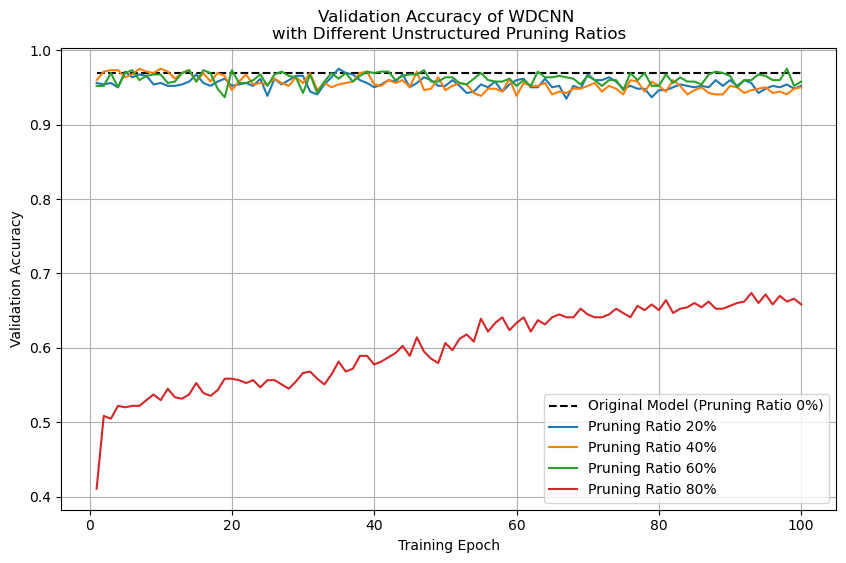


✅ Graph Generated!


In [8]:
# ============================================================
# 🔹 Validation Accuracy 그래프 출력 (Original Model 포함)
# ============================================================
print("\n🔹 Plotting Unstructured Pruning Validation Accuracy Graph...")
plot_unstructured_pruning_results(experiment_results, num_epochs=100, val_loader=val_loader, include_original=True)
print("\n✅ Graph Generated!")


### Cell 1.1.3 Test 성능 평가

In [9]:
## ✅ Cell 1.3: Test Performance Evaluation (Inference 포함 - Unstructured)
print("\n🔹 Final Test Performance Evaluation for Unstructured Pruning (Including Inference Time)...")
evaluate_test_performance_unstructured(original_model, test_loader, device, experiment_results, unstructured_path)


🔹 Final Test Performance Evaluation for Unstructured Pruning (Including Inference Time)...


,Pruning Ratio,Number of Non-Zero Params,Inference Time (s),Test Accuracy
0,0.0,41404,0.001232,0.961612
1,0.2,33281,0.001410,0.961612
2,0.4,25161,0.001430,0.969290
3,0.6,17039,0.001354,0.953935
4,0.8,8919,0.001282,0.667946


## Cell 1.2 Structured Pruning

### Cell 1.2.1 Fine-Tuning

In [11]:
# ============================================================
# 🔹 Structured Pruning Fine-Tuning 수행 (1번만)
# ============================================================
structured_pruning_ratios = [0.2, 0.4, 0.6, 0.8]

# 🔹 저장된 Fine-Tuning 결과가 있는지 확인
structured_experiment_results_path = os.path.join(structured_path, "structured_experiment_results.pkl")
structured_experiment_results = None

if os.path.exists(structured_experiment_results_path):
    with open(structured_experiment_results_path, "rb") as f:
        structured_experiment_results = pickle.load(f)
    print("\n✅ 기존 Structured Fine-Tuning 결과를 불러왔습니다. 학습을 건너뜁니다.")
else:
    print("\n🔹 Starting Structured Pruning Fine-Tuning...")
    structured_experiment_results = fine_tune_structured(structured_pruning_ratios, train_loader, val_loader, num_epochs=100)
    print("\n✅ Structured Pruning Fine-Tuning Completed!")



🔹 Starting Structured Pruning Fine-Tuning...

🔹 Fine-tuning with Structured Pruning Amount: 0.2
Epoch 1/100 - Pruning 0.2: Train Acc: 0.9866, Val Acc: 0.9347
Epoch 2/100 - Pruning 0.2: Train Acc: 0.9761, Val Acc: 0.9578
Epoch 3/100 - Pruning 0.2: Train Acc: 0.9761, Val Acc: 0.9578
Epoch 4/100 - Pruning 0.2: Train Acc: 0.9674, Val Acc: 0.9635
Epoch 5/100 - Pruning 0.2: Train Acc: 0.9755, Val Acc: 0.9674
Epoch 6/100 - Pruning 0.2: Train Acc: 0.9883, Val Acc: 0.9539
Epoch 7/100 - Pruning 0.2: Train Acc: 0.9819, Val Acc: 0.9578
Epoch 8/100 - Pruning 0.2: Train Acc: 0.9907, Val Acc: 0.9616
Epoch 9/100 - Pruning 0.2: Train Acc: 0.9720, Val Acc: 0.9655
Epoch 10/100 - Pruning 0.2: Train Acc: 0.9837, Val Acc: 0.9597
Epoch 11/100 - Pruning 0.2: Train Acc: 0.9872, Val Acc: 0.9616
Epoch 12/100 - Pruning 0.2: Train Acc: 0.9808, Val Acc: 0.9578
Epoch 13/100 - Pruning 0.2: Train Acc: 0.9802, Val Acc: 0.9655
Epoch 14/100 - Pruning 0.2: Train Acc: 0.9761, Val Acc: 0.9655
Epoch 15/100 - Pruning 0.2: Tr

### Cell 1.2.2 Graph


🔹 Plotting Structured Pruning Validation Accuracy Graph...

🔹 Calculating Original Model Validation Accuracy for Graph...


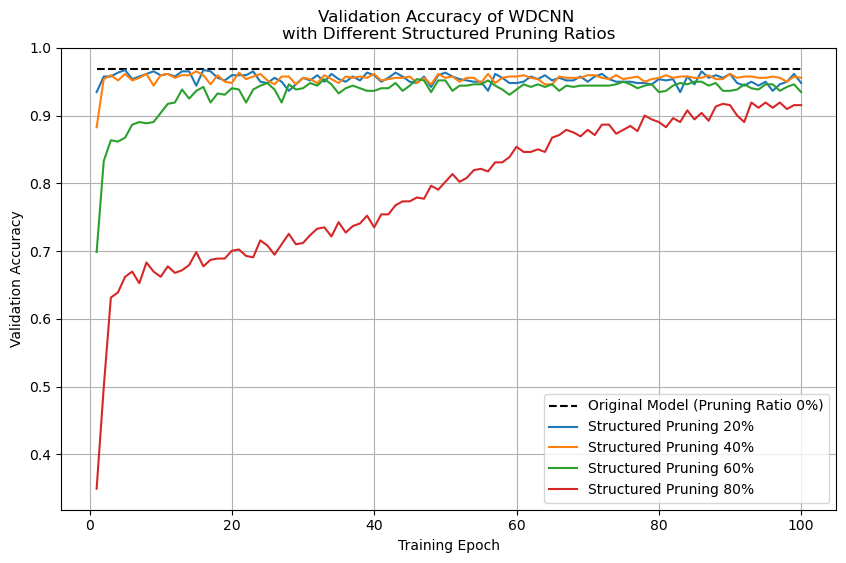


✅ Graph Generated!


In [12]:
## ✅ Cell 2.2: Validation Accuracy 그래프 출력
print("\n🔹 Plotting Structured Pruning Validation Accuracy Graph...")
plot_structured_pruning_results(structured_experiment_results, num_epochs=100, val_loader=val_loader, include_original=True)
print("\n✅ Graph Generated!")

### Cell 1.2.3 Test 성능 평가

In [13]:
## ✅ Cell 2.3: Test Performance Evaluation (Inference 포함 - Structured)
print("\n🔹 Final Test Performance Evaluation for Structured Pruning (Including Inference Time)...")
evaluate_test_performance_structured(original_model, test_loader, device, structured_experiment_results, structured_path)


🔹 Final Test Performance Evaluation for Structured Pruning (Including Inference Time)...


,Pruning Ratio,Number of Non-Zero Params,Inference Time (s),Test Accuracy
0,0.0,41404,0.001243,0.961612
1,0.2,34684,0.001655,0.963532
2,0.4,27916,0.001277,0.942418
3,0.6,21612,0.001516,0.928983
4,0.8,14844,0.001334,0.900192


# Cell 2. Iterative Magnitude Pruning

실험 전체적인 개요  
[Cell 3.1 20%씩 10회 Pruning 하기]
- 각 Pruning Ratio별 Test Acc -> Table로 나중에 제시할 것
- Validation Acc -> Graph

- 30회 코드


🔹 Iteration 1: Percent of Weights Remaining 100.0%

🔹 Iteration 2: Percent of Weights Remaining 80.0%

🔹 Iteration 3: Percent of Weights Remaining 64.00000000000001%

🔹 Iteration 4: Percent of Weights Remaining 51.20000000000001%

🔹 Iteration 5: Percent of Weights Remaining 40.96000000000001%

🔹 Iteration 6: Percent of Weights Remaining 32.76800000000001%

🔹 Iteration 7: Percent of Weights Remaining 26.21440000000001%

🔹 Iteration 8: Percent of Weights Remaining 20.97152000000001%

🔹 Iteration 9: Percent of Weights Remaining 16.77721600000001%

🔹 Iteration 10: Percent of Weights Remaining 13.421772800000006%

🔹 Iteration 11: Percent of Weights Remaining 10.737418240000006%

🔹 Iteration 12: Percent of Weights Remaining 8.589934592000006%

🔹 Iteration 13: Percent of Weights Remaining 6.871947673600004%

🔹 Iteration 14: Percent of Weights Remaining 5.497558138880003%

🔹 Iteration 15: Percent of Weights Remaining 4.3980465111040035%

🔹 Iteration 16: Percent of Weights Remaining 3.51843720

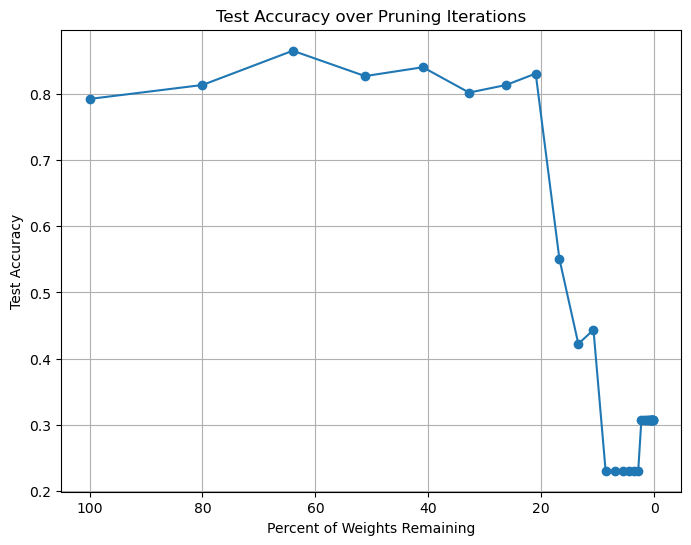

    Percent of Weights Remaining  Validation Accuracy  Test Accuracy
0                     100.000000             0.813820       0.792706
1                      80.000000             0.838772       0.813820
2                      64.000000             0.865643       0.865643
3                      51.200000             0.825336       0.827255
4                      40.960000             0.838772       0.840691
5                      32.768000             0.798464       0.802303
6                      26.214400             0.815739       0.813820
7                      20.971520             0.831094       0.831094
8                      16.777216             0.537428       0.550864
9                      13.421773             0.412668       0.422265
10                     10.737418             0.428023       0.443378
11                      8.589935             0.230326       0.230326
12                      6.871948             0.230326       0.230326
13                      5.497558  

,Percent of Weights Remaining,Validation Accuracy,Test Accuracy
0,100.000000,0.813820,0.792706
1,80.000000,0.838772,0.813820
2,64.000000,0.865643,0.865643
3,51.200000,0.825336,0.827255
4,40.960000,0.838772,0.840691
5,32.768000,0.798464,0.802303
6,26.214400,0.815739,0.813820
7,20.971520,0.831094,0.831094
8,16.777216,0.537428,0.550864
9,13.421773,0.412668,0.422265


In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
from model import WDCNN
from utils import remove_pruning_and_save_unstructured, evaluate_classification
import torch.nn.utils.prune as prune

# 경로 설정
original_model_path = r"C:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\Parameters\Original\best_overall_model.pth"
initial_weights_path = r"C:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\Parameters\Original\initial_weights_bs256.pth"
iterative_save_path = r"C:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\Parameters\Iterative_Unstructured"
os.makedirs(iterative_save_path, exist_ok=True)

# Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Percent of Weights Remaining
pruning_steps = [100 * (0.8 ** i) for i in range(30)]

# Dataset 로드
train_dataset, val_dataset, test_dataset = (
    CWRUDataset("Train"), CWRUDataset("Validation"), CWRUDataset("Test")
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

val_accs = []
test_accs = []

# 초기 모델 로드 및 초기화 저장
pruned_model = WDCNN().to(device)
pruned_model.load_state_dict(torch.load(initial_weights_path, map_location=device))
initial_weights = torch.load(initial_weights_path, map_location=device)

for step, perc in enumerate(pruning_steps):
    print(f"\n🔹 Iteration {step+1}: Percent of Weights Remaining {perc}%")

    # Pruning 적용 (매 Iteration마다 추가 Pruning)
    pruning_amount = 0.2
    for name, module in pruned_model.named_modules():
        if isinstance(module, (nn.Conv1d, nn.Linear)):
            prune.l1_unstructured(module, name="weight", amount=pruning_amount)

    # Mask된 부분에 initial weights 적용
    with torch.no_grad():
        for name, module in pruned_model.named_modules():
            if isinstance(module, (nn.Conv1d, nn.Linear)) and hasattr(module, 'weight_mask'):
                init_param = initial_weights[f"{name}.weight"]
                mask = module.weight_mask
                module.weight_orig.copy_(init_param * mask)

    # Fine-tuning
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(pruned_model.parameters(), lr=1e-5)

    best_val_acc = 0.0
    best_pruned_model = None

    for epoch in range(100):
        pruned_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = pruned_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        pruned_model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = pruned_model(inputs)
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()
        val_acc = val_correct / len(val_dataset)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_pruned_model = deepcopy(pruned_model)

    # 최적 모델 저장
    model_save_path = os.path.join(iterative_save_path, f"pruned_{perc:.６f}.pth")
    remove_pruning_and_save_unstructured(best_pruned_model, model_save_path)

    # Validation Accuracy 기록
    val_accs.append(best_val_acc)

    # Test Accuracy 평가
    best_pruned_model.eval()
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_pruned_model(inputs)
            test_correct += (outputs.argmax(dim=1) == labels).sum().item()
    test_acc = test_correct / len(test_dataset)
    test_accs.append(test_acc)

# 결과 시각화
plt.figure(figsize=(8, 6))
plt.plot(pruning_steps, test_accs, marker='o', linestyle='-')
plt.xlabel('Percent of Weights Remaining')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Pruning Iterations')
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

# Test Accuracy 표 출력
import pandas as pd
df = pd.DataFrame({
    'Percent of Weights Remaining': pruning_steps,
    'Validation Accuracy': val_accs,
    'Test Accuracy': test_accs
})
print(df)
display(df)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
from model import WDCNN
from utils import apply_sparse_training, remove_pruning_and_save_unstructured, evaluate_classification

# 경로 설정
original_model_path = r"C:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\Parameters\Original\best_overall_model.pth"
initial_weights_path = r"C:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\Parameters\Original\initial_weights_bs256.pth"
iterative_save_path = r"C:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\Parameters\Iterative_Unstructured"
os.makedirs(iterative_save_path, exist_ok=True)

# Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Percent of Weights Remaining
pruning_steps = [100 * (0.8 ** i) for i in range(30)]

# Dataset 로드
train_dataset, val_dataset, test_dataset = (
    CWRUDataset("Train"), CWRUDataset("Validation"), CWRUDataset("Test")
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

val_accs = []
test_accs = []

pruned_model = None
mask = None

for step, perc in enumerate(pruning_steps):
    print(f"\n🔹 Iteration {step+1}: Percent of Weights Remaining {perc}%")

    # 모델 로드
    model = WDCNN().to(device)
    model.load_state_dict(torch.load(initial_weights_path, map_location=device))

    # Pruning 적용 (무조건 20%씩 Pruning)
    pruning_amount = 0.2
    pruned_model = apply_sparse_training(model, amount=pruning_amount)

    # Mask된 부분에 initial weights 적용
    initial_weights = torch.load(initial_weights_path, map_location=device)
    with torch.no_grad():
        for name, module in pruned_model.named_modules():
            if isinstance(module, (nn.Conv1d, nn.Linear)) and hasattr(module, 'weight_mask'):
                init_param = initial_weights[f"{name}.weight"]
                mask = module.weight_mask
                module.weight_orig.copy_(init_param * mask)

    # Fine-tuning
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(pruned_model.parameters(), lr=1e-5)

    best_val_acc = 0.0
    best_pruned_model = None

    for epoch in range(100):
        pruned_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = pruned_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        pruned_model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = pruned_model(inputs)
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()
        val_acc = val_correct / len(val_dataset)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_pruned_model = deepcopy(pruned_model)

    # 최적 모델 저장
    model_save_path = os.path.join(iterative_save_path, f"pruned_{perc:.1f}.pth")
    remove_pruning_and_save_unstructured(best_pruned_model, model_save_path)

    # Validation Accuracy 기록
    val_accs.append(best_val_acc)

    # Test Accuracy 평가
    best_pruned_model.eval()
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_pruned_model(inputs)
            test_correct += (outputs.argmax(dim=1) == labels).sum().item()
    test_acc = test_correct / len(test_dataset)
    test_accs.append(test_acc)

# 결과 시각화
plt.figure(figsize=(8, 6))
plt.plot(pruning_steps, val_accs, marker='o', linestyle='-')
plt.xlabel('Percent of Weights Remaining')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Pruning Iterations')
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

# Test Accuracy 표 출력
import pandas as pd
df = pd.DataFrame({
    'Percent of Weights Remaining': pruning_steps,
    'Validation Accuracy': val_accs,
    'Test Accuracy': test_accs
})
print(df)
display(df)
